<a href="https://colab.research.google.com/github/valcsuremm/GU-5423/blob/main/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project Code: Applied Data Science

### Connecting Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


### Installing and importing packages

In [ ]:
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl

import cv2
from skimage.util import img_as_ubyte

import torch
from urllib.parse import urlparse
import shutil

from tifffile import imwrite
from google.colab import drive

import pandas as pd
import skimage.measure
import skimage.exposure

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report
import skimage

import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 37.9 MB/s eta 0:00:00
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0.2
    Uninstalling PyYAML-6.0.2:
      Successfully uninstalled PyYAML-6.0.2


### Reconnected? Open these files:

1. df (original dataframe) Form ID; Line ID; Writer ID;	Text; Image Path

In [ ]:
csv_path = '/content/gdrive/MyDrive/P3/handwriting_metadata.csv'
df = pd.read_csv(csv_path)

In [ ]:
df.head()

,Form ID,Line ID,Writer ID,Text,Image Path
0,e01-062,e01-062-00,213,"In the home, crochet lace can be used to make",/content/gdrive/MyDrive/P3/lines/e01/e01-062/e...
1,e01-062,e01-062-01,213,"tablecloths, traycloths and runners, and edgings",/content/gdrive/MyDrive/P3/lines/e01/e01-062/e...
2,e01-062,e01-062-02,213,from heavy to fine can fulfil a variety of,/content/gdrive/MyDrive/P3/lines/e01/e01-062/e...
3,e01-062,e01-062-03,213,functions. The art of crochet is not difficult...,/content/gdrive/MyDrive/P3/lines/e01/e01-062/e...
4,e01-062,e01-062-04,213,it is reasonably quick to work. In the following,/content/gdrive/MyDrive/P3/lines/e01/e01-062/e...


2. Pairs file:

In [ ]:
csv_path = '/content/gdrive/MyDrive/P3/pairs.csv'
pairs_df = pd.read_csv(csv_path)

In [ ]:
pairs_df
print(pairs_df.dtypes) #line id, writer id, image path 1 and 2

Line ID 1       object
Writer ID 1      int64
Image Path 1    object
Line ID 2       object
Writer ID 2      int64
Image Path 2    object
dtype: object


In [ ]:
invalid_image_paths = df[df['Image Path'].isnull()]
invalid_image_paths #should be none :)

,Form ID,Line ID,Writer ID,Text,Image Path


In [ ]:
invalid_image_paths = pairs_df[pairs_df['Image Path 1'].isnull() | pairs_df['Image Path 2'].isnull()]

# Print the rows with invalid paths
print(invalid_image_paths) #should be none

Empty DataFrame
Columns: [Line ID 1, Writer ID 1, Image Path 1, Line ID 2, Writer ID 2, Image Path 2]
Index: []


3. List indices (randomly selected, previosuly and as of now, k = 30000)

In [ ]:
csv_path = '/content/gdrive/MyDrive/P3/list_indices.csv'
indices_df = pd.read_csv(csv_path)

In [ ]:
csv_path = '/content/gdrive/MyDrive/P3/subset_filtered_final.csv'
subset_filtered_real = pd.read_csv(csv_path)

4a. Pairs which have not undergone processing but there are 30k of them, taken from original 86 million pair dataset.

In [ ]:
csv_path = '/content/gdrive/MyDrive/P3/filtered_30k.csv'
filtered_pairs_df = pd.read_csv(csv_path)

4. Processed images, train-test split are below

In [ ]:
data_path = "/content/gdrive/MyDrive/P3"  # Input directory
input_dir = os.path.join(data_path, "")

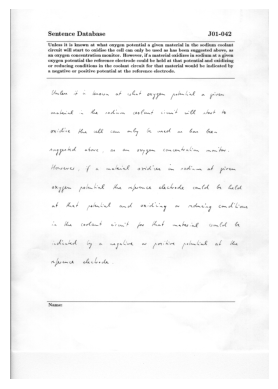

In [ ]:
sample_form_path = os.path.join(data_path, 'formsI-Z/j01-042.png')
img = Image.open(sample_form_path)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show() #this would be considered an individual form rather than a word, sentence, or line

### Parsing XML file

"XML tree and elements:

XML is an inherently hierarchical data format, and the most natural way to represent it is with a tree. ET has two classes for this purpose - ElementTree represents the whole XML document as a tree, and Element represents a single node in this tree. Interactions with the whole document (reading and writing to/from files) are usually done on the ElementTree level. Interactions with a single XML element and its sub-elements are done on the Element level." - Python documentation (https://docs.python.org/3/library/xml.etree.elementtree.html)

This next part of my code is heavily informed by the Python documentation.

"Element has some useful methods that help iterate recursively over all the sub-tree below it (its children, their children, and so on). For example, Element.iter():

>>
for neighbor in root.iter('neighbor'):
    ...

Element.findall() finds only elements with a tag which are direct children of the current element. Element.find() finds the first child with a particular tag, and Element.text accesses the element’s text content. Element.get() accesses the element’s attributes."

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
# xml path
xml_dir = "/content/gdrive/MyDrive/P3/xml"

data = []

for xml_file in os.listdir(xml_dir):
    if xml_file.endswith(".xml"):
        tree = ET.parse(os.path.join(xml_dir, xml_file))
        root = tree.getroot()

        writer_id = root.attrib.get('writer-id', None)
        form_id = root.attrib.get('id', None)

        for line in root.findall(".//line"):
            line_id = line.attrib.get('id', None)
            text = line.attrib.get('text', "")
            #storing the data I want
            data.append({
                "Form ID": form_id,
                "Line ID": line_id,
                "Writer ID": writer_id,
                "Text": text
            })

df = pd.DataFrame(data)

# Saved to CSV
df.to_csv('/content/gdrive/MyDrive/P3/handwriting_metadata.csv', index=False)

print(df.head())


   Form ID     Line ID Writer ID  \
0  e01-062  e01-062-00       213   
1  e01-062  e01-062-01       213   
2  e01-062  e01-062-02       213   
3  e01-062  e01-062-03       213   
4  e01-062  e01-062-04       213   

                                                Text  
0      In the home, crochet lace can be used to make  
1   tablecloths, traycloths and runners, and edgings  
2         from heavy to fine can fulfil a variety of  
3  functions. The art of crochet is not difficult...  
4   it is reasonably quick to work. In the following  


Now I am going to match the metadata with my images. First, I'm going to do it on the "lines" basis. If it's possible to do it on the lines basis, I'd like to expand to words.

First, I construct the image path.

In [ ]:
lines_dir = "/content/gdrive/MyDrive/P3/lines"

image_paths = []

for line_id in df['Line ID']:
    # splitting the line ID by the hyphen (can't do number of characters because those can change)
    parts = line_id.split('-')

    if len(parts) >= 2: #need a first folder and then a subfolder
        first_level_folder = parts[0]

        second_level_folder = '-'.join(parts[:2])

        image_path = os.path.join(lines_dir, first_level_folder, second_level_folder, f"{line_id}.png") #creating the image path based on the paths given in xml

        if os.path.exists(image_path): #check if it exists... like i learned in data strucs
            image_paths.append(image_path)
        else:
            image_paths.append(None)
    else:
        image_paths.append(None)

df['Image Path'] = image_paths

df.head()

       Form ID     Line ID  Writer ID  \
0      e01-062  e01-062-00        213   
1      e01-062  e01-062-01        213   
2      e01-062  e01-062-02        213   
3      e01-062  e01-062-03        213   
4      e01-062  e01-062-04        213   
...        ...         ...        ...   
13348  e01-081  e01-081-01        214   
13349  e01-081  e01-081-02        214   
13350  e01-081  e01-081-03        214   
13351  e01-081  e01-081-04        214   
13352  e01-081  e01-081-05        214   

                                                    Text  \
0          In the home, crochet lace can be used to make   
1       tablecloths, traycloths and runners, and edgings   
2             from heavy to fine can fulfil a variety of   
3      functions. The art of crochet is not difficult...   
4       it is reasonably quick to work. In the following   
...                                                  ...   
13348  shape, ensuring that all lines of the crochet are   
13349  accurate. Place croc

In [ ]:
df.to_csv('/content/gdrive/MyDrive/P3/handwriting_metadata.csv', index=False) #to save just in case (lots of saving in this project)

,Form ID,Line ID,Writer ID,Text,Image Path
0,e01-062,e01-062-00,213,"In the home, crochet lace can be used to make",/content/gdrive/MyDrive/P3/lines/e01/e01-062/e...
1,e01-062,e01-062-01,213,"tablecloths, traycloths and runners, and edgings",/content/gdrive/MyDrive/P3/lines/e01/e01-062/e...
2,e01-062,e01-062-02,213,from heavy to fine can fulfil a variety of,/content/gdrive/MyDrive/P3/lines/e01/e01-062/e...
3,e01-062,e01-062-03,213,functions. The art of crochet is not difficult...,/content/gdrive/MyDrive/P3/lines/e01/e01-062/e...
4,e01-062,e01-062-04,213,it is reasonably quick to work. In the following,/content/gdrive/MyDrive/P3/lines/e01/e01-062/e...


Now I am creating pairs of images which will be used for comparison since I am looking for a Yes/No outcome (match/no match) when determining the writers.

In [ ]:
pairs = []

line_ids = df['Line ID'].tolist()
writer_ids = df['Writer ID'].tolist()
image_path = df['Image Path'].tolist()

for i in range(len(line_ids)):
    for j in range(i + 1, len(line_ids)):  # avoiding duplicats
        pairs.append({
            "Line ID 1": line_ids[i],
            "Writer ID 1": writer_ids[i],
            "Image Path 1": image_path[i],
            "Line ID 2": line_ids[j],
            "Writer ID 2": writer_ids[j],
            "Image Path 2": image_path[j]
        })


# to a df (better to save for csv i think?)
pairs_df = pd.DataFrame(pairs)

pairs_df.head()


           Line ID 1  Writer ID 1  \
0         e01-062-00          213   
1         e01-062-00          213   
2         e01-062-00          213   
3         e01-062-00          213   
4         e01-062-00          213   
...              ...          ...   
89144623  e01-081-02          214   
89144624  e01-081-02          214   
89144625  e01-081-03          214   
89144626  e01-081-03          214   
89144627  e01-081-04          214   

                                               Image Path 1   Line ID 2  \
0         /content/gdrive/MyDrive/P3/lines/e01/e01-062/e...  e01-062-01   
1         /content/gdrive/MyDrive/P3/lines/e01/e01-062/e...  e01-062-02   
2         /content/gdrive/MyDrive/P3/lines/e01/e01-062/e...  e01-062-03   
3         /content/gdrive/MyDrive/P3/lines/e01/e01-062/e...  e01-062-04   
4         /content/gdrive/MyDrive/P3/lines/e01/e01-062/e...  e01-062-05   
...                                                     ...         ...   
89144623  /content/gdrive/MyDr

In [ ]:
pairs_df.to_csv('/content/gdrive/MyDrive/P3/pairs.csv', index=False)


Obviously this is a huge daataset with 89 million pairs. I would probably choose some randomly because this is way too many to go through. Right now, I'm selecting 30,000 pairs WITH replacement.

In [ ]:
list1 = list(range(pairs_df.shape[0]))
list_indices = random.choices(list1, k = 30000)

In [ ]:
indices_df = pd.DataFrame(list_indices, columns=["Index"])
file_path = '/content/gdrive/MyDrive/P3/list_indices.csv'
indices_df.to_csv(file_path, index=False)

### Filtering to randomly select pairs

In [ ]:
filtered_pairs_df = pairs_df.iloc[indices_df['Index']]
filtered_pairs_df #30,000 rows! worked correctly :)

IndexError: positional indexers are out-of-bounds

### Preprocessing images

The images came segmented, so I resized the images to start. I read in the images in grayscale because they were scanned as such in the original dataset. This also would make it theoretically easier to add images to the dataset in the future (for example if there were photocopies used or something, the inputs would be more standardized). In my opinion, ink color could actually decrease the effectiveness of the writer detection by confusing the model.

In [ ]:
def preprocess_image(image_path, target_size=(128, 128)):
    # reading in the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None

    # resized to target of 128x128
    img_resized = cv2.resize(img, target_size)

    # normalized values pixel values to range [0, 1]
    img_normalized = img_resized / 255.0 #(used float so it will turn into a float)

    return img_normalized


Below, I am trying out my code to see if the preprocessing works and get an idea of the time.

In [ ]:
subset_filtered = filtered_pairs_df.iloc[:25]

In [ ]:
subset_filtered['Image 1 Array'] = subset_filtered['Image Path 1'].apply(preprocess_image)
subset_filtered['Image 2 Array'] = subset_filtered['Image Path 2'].apply(preprocess_image)
print(subset_filtered.head())


<ipython-input-32-c13878bce522>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_filtered['Image 1 Array'] = subset_filtered['Image Path 1'].apply(preprocess_image)
<ipython-input-32-c13878bce522>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_filtered['Image 2 Array'] = subset_filtered['Image Path 2'].apply(preprocess_image)


    Line ID 1  Writer ID 1                                       Image Path 1  \
0  g03-043-07          314  /content/gdrive/MyDrive/P3/lines/g03/g03-043/g...   
1  h07-080-05          391  /content/gdrive/MyDrive/P3/lines/h07/h07-080/h...   
2  m04-131-03          547  /content/gdrive/MyDrive/P3/lines/m04/m04-131/m...   
3  r03-110-07          668  /content/gdrive/MyDrive/P3/lines/r03/r03-110/r...   
4  e04-119-02          243  /content/gdrive/MyDrive/P3/lines/e04/e04-119/e...   

     Line ID 2  Writer ID 2  \
0   m02-095-09          532   
1   m04-209-05          549   
2   n04-039-05          582   
3   b04-004-05          107   
4  g06-037l-08          343   

                                        Image Path 2  \
0  /content/gdrive/MyDrive/P3/lines/m02/m02-095/m...   
1  /content/gdrive/MyDrive/P3/lines/m04/m04-209/m...   
2  /content/gdrive/MyDrive/P3/lines/n04/n04-039/n...   
3  /content/gdrive/MyDrive/P3/lines/b04/b04-004/b...   
4  /content/gdrive/MyDrive/P3/lines/g06/g06-03

Example image... wondering if the warped shape will have a negative impact. Hopefully not, it'll be the same thing applied to each of them!

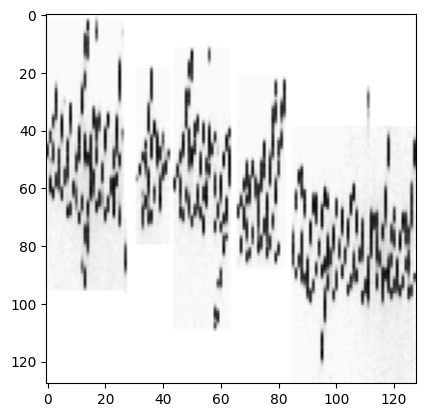

In [ ]:
image1 = np.array(subset_filtered.iloc[0]['Image 1 Array']).reshape(128, 128)

plt.imshow(image1, cmap='gray')
plt.show()

In [ ]:
filtered_pairs_df.to_csv('/content/gdrive/MyDrive/P3/filtered_30k.csv', index=False)

Due to time constraints (image processing was predicted to take 7 hours for 30k pairs 🥲), I started with around 8000 pairs. Below, I augment the dataset's matching pairs.

In [ ]:
filtered_pairs_df.columns
matching_rows = filtered_pairs_df[filtered_pairs_df['Writer ID 1'] == filtered_pairs_df['Writer ID 2']]

row_nums = matching_rows.index[:200] #augmenting the dataset

In [ ]:
subset_filtered_real = filtered_pairs_df.iloc[:8000]
rows_to_append = filtered_pairs_df.loc[row_nums]

subset_filtered_real = pd.concat([subset_filtered_real, rows_to_append]) #concatenate to add these rows

         Line ID 1  Writer ID 1  \
0       g03-043-07          314   
1       h07-080-05          391   
2       m04-131-03          547   
3       r03-110-07          668   
4       e04-119-02          243   
...            ...          ...   
28960  a01-128u-09            0   
28974   b06-019-01          128   
29062  g06-011l-01          343   
29365  a01-049x-10            0   
29894  c03-003b-04          151   

                                            Image Path 1    Line ID 2  \
0      /content/gdrive/MyDrive/P3/lines/g03/g03-043/g...   m02-095-09   
1      /content/gdrive/MyDrive/P3/lines/h07/h07-080/h...   m04-209-05   
2      /content/gdrive/MyDrive/P3/lines/m04/m04-131/m...   n04-039-05   
3      /content/gdrive/MyDrive/P3/lines/r03/r03-110/r...   b04-004-05   
4      /content/gdrive/MyDrive/P3/lines/e04/e04-119/e...  g06-037l-08   
...                                                  ...          ...   
28960  /content/gdrive/MyDrive/P3/lines/a01/a01-128u/...   a05-116-0

In [ ]:
labels = (subset_filtered_real["Writer ID 1"] == subset_filtered_real["Writer ID 2"]).astype(int)
np.unique(labels, return_counts=True)

(array([0, 1]), array([7964,  171]))

In [ ]:
#im7 = pre_images['/content/gdrive/MyDrive/P3/lines/f07/f07-028a/f07-028a-02.png'] just testing something here

In [ ]:
pre_images = {}
start = time.time()
for i, path in enumerate(set(subset_filtered_real['Image Path 1']).union(set(subset_filtered_real['Image Path 2']))): #all of the paths used
  pre_images[path] = preprocess_image(path)
  pd.DataFrame(pre_images[path]).to_csv(path.split('.png')[0]+'.csv') #should save to a csv with commas intact
  if i % 50 == 0:
    print(i)
    print(f"Time elapsed: {time.time() - start} seconds") #getting idea of time

0
Time elapsed: 0.024152040481567383 seconds
50
Time elapsed: 1.2039203643798828 seconds
100
Time elapsed: 33.59001874923706 seconds
150
Time elapsed: 82.93981766700745 seconds
200
Time elapsed: 130.91678404808044 seconds
250
Time elapsed: 182.76756858825684 seconds
300
Time elapsed: 230.6399257183075 seconds
350
Time elapsed: 279.43396162986755 seconds
400
Time elapsed: 329.3410544395447 seconds
450
Time elapsed: 377.74485206604004 seconds
500
Time elapsed: 425.00610995292664 seconds
550
Time elapsed: 473.54866909980774 seconds
600
Time elapsed: 521.0999915599823 seconds
650
Time elapsed: 568.7176351547241 seconds
700
Time elapsed: 616.0785112380981 seconds
750
Time elapsed: 662.2827990055084 seconds
800
Time elapsed: 709.7393600940704 seconds
850
Time elapsed: 757.5043566226959 seconds
900
Time elapsed: 801.9212477207184 seconds
950
Time elapsed: 847.5827708244324 seconds
1000
Time elapsed: 895.33611536026 seconds
1050
Time elapsed: 942.8040194511414 seconds
1100
Time elapsed: 991.01

In [ ]:
# pre_images = {} # only if disconnects
# for path in set(subset_filtered_real['Image Path 1']).union(set(subset_filtered_real['Image Path 2'])):
#   df = pd.read_csv(path.split('.png')[0]+'.csv', index_col=0)
#   # pre_images[path] = pd.read_csv(path.split('.png')[0]+'.csv', index_col=0)

In [ ]:
subset_filtered_real['Image 1 Array'] = subset_filtered_real['Image Path 1'].map(pre_images)
subset_filtered_real['Image 2 Array'] = subset_filtered_real['Image Path 2'].map(pre_images)

In [ ]:
file_path = '/content/gdrive/MyDrive/P3/subset_processed_forREALTHISTIME.csv'
subset_processed = pd.read_csv(file_path) #loading stuff, no longer relevant I think

In [ ]:
filepath ='/content/gdrive/MyDrive/P3/subset_processed.csv'
subset_processed = pd.read_csv(filepath)
subset_processed.head()

,Line ID 1,Writer ID 1,Image Path 1,Line ID 2,Writer ID 2,Image Path 2
0,g03-043-07,314,/content/gdrive/MyDrive/P3/lines/g03/g03-043/g...,m02-095-09,532,/content/gdrive/MyDrive/P3/lines/m02/m02-095/m...
1,h07-080-05,391,/content/gdrive/MyDrive/P3/lines/h07/h07-080/h...,m04-209-05,549,/content/gdrive/MyDrive/P3/lines/m04/m04-209/m...
2,m04-131-03,547,/content/gdrive/MyDrive/P3/lines/m04/m04-131/m...,n04-039-05,582,/content/gdrive/MyDrive/P3/lines/n04/n04-039/n...
3,r03-110-07,668,/content/gdrive/MyDrive/P3/lines/r03/r03-110/r...,b04-004-05,107,/content/gdrive/MyDrive/P3/lines/b04/b04-004/b...
4,e04-119-02,243,/content/gdrive/MyDrive/P3/lines/e04/e04-119/e...,g06-037l-08,343,/content/gdrive/MyDrive/P3/lines/g06/g06-037l/...


## Building and Training a CNN

Scary!!

Imports: import tensorflow as tf; from tensorflow.keras import layers, models (inserted above but it's for this section)

This section is informed by TensorFlow documentation 🙏
forever grateful for this documentation ➡ https://www.tensorflow.org/tutorials/images/cnn (cited in paper)

In [ ]:
def model(
    input_shape=(128, 128, 1)): # = input_shape=(32, 32, 3) in documentation but mine is different

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
image_1_arrays = np.array(subset_filtered_real["Image 1 Array"].tolist())
image_2_arrays = np.array(subset_filtered_real["Image 2 Array"].tolist())

In [ ]:
subset_filtered_real.columns

Index(['Line ID 1', 'Writer ID 1', 'Image Path 1', 'Line ID 2', 'Writer ID 2',
       'Image Path 2', 'Image 1 Array', 'Image 2 Array'],
      dtype='object')

### Train-test split

In [ ]:
inputs = np.stack((image_1_arrays, image_2_arrays), axis=1)  # shape (n, 2, 128, 128) --- horizontal stack

X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2)

X_train_1 = X_train[:, 0]  # First img in pair (col 0)
X_train_2 = X_train[:, 1]
X_test_1 = X_test[:, 0]
X_test_2 = X_test[:, 1]

#tuples
train_data = (X_train_1, X_train_2)
test_data = (X_test_1, X_test_2)

In [ ]:
pd.DataFrame(inputs.reshape(inputs.shape[0], -1)).to_csv('/content/gdrive/MyDrive/P3/inputs_for_cnn.csv', index=False)

KeyboardInterrupt: 

In [ ]:
print(train_data[0].dtype)
print(train_data[1].dtype)
print(y_train.dtype)
print(test_data[0].dtype)
print(test_data[1].dtype)
print(y_test.dtype) #making sure the types all make sense, int and float would be perfect!

float64
float64
int64
float64
float64
int64


In [ ]:
fitted = model.fit(
    [train_data[0], train_data[1]],  # pairs of inputs
    y_train,  # Labels
    validation_data=([test_data[0], test_data[1]], y_test),
    epochs=10,
    batch_size=32 #kind of arbitrary choice
)


Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9520 - loss: 0.1434 - val_accuracy: 0.9730 - val_loss: 0.1296
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9790 - loss: 0.1062 - val_accuracy: 0.9730 - val_loss: 0.1265
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9796 - loss: 0.1016 - val_accuracy: 0.9730 - val_loss: 0.1213
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9820 - loss: 0.0876 - val_accuracy: 0.9730 - val_loss: 0.1329
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9808 - loss: 0.0872 - val_accuracy: 0.9730 - val_loss: 0.1157
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9818 - loss: 0.0692 - val_accuracy: 0.9754 - val_loss: 0.1061
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9859 - loss: 0.0530 - val_accuracy: 0.9766 - val_loss: 0.1317
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9884 - loss: 0.0376 - val_accu

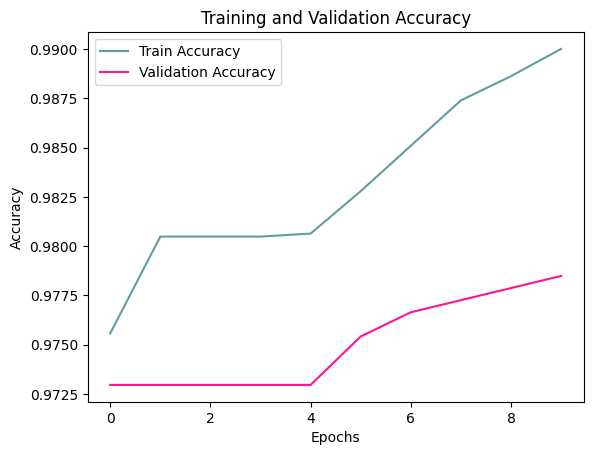

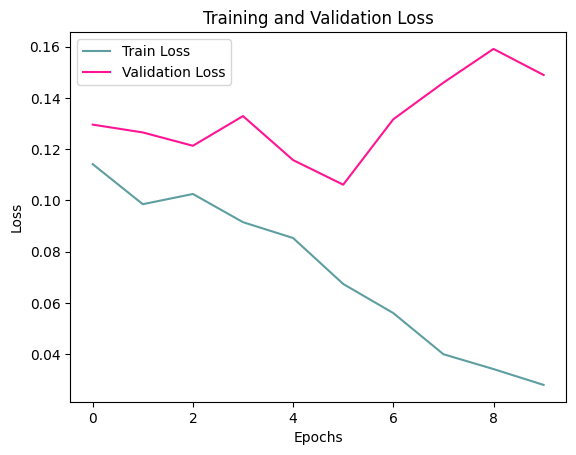

In [ ]:
plt.plot(fitted.history['accuracy'], label='Train Accuracy', color = "cadetblue") #used chatgpt and matplotlib for some documentenation related to formatting these graphs
plt.plot(fitted.history['val_accuracy'], label='Validation Accuracy', color = 'deeppink')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(fitted.history['loss'], label='Train Loss',  color = "cadetblue")
plt.plot(fitted.history['val_loss'], label='Validation Loss', color = 'deeppink')
plt.title('Training and Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


The graph shows that the model struggles more on data it hasn't seen before, but not enough for me to be concerned about overfitting. Loss stops improving after epochs 7 and 8.

In [ ]:
predictions = model.predict([test_data[0], test_data[1]])
print(predictions[:5])  # Printing first 5 predictions to see if outputs make sense

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[[0.00080595]
 [0.00040788]
 [0.00551129]
 [0.00173959]
 [0.00091726]]


In [ ]:
# make probs into binary preds
binary_predictions = (predictions > 0.5).astype(int)

print(binary_predictions[:5]) #should be = 0


[[0]
 [0]
 [0]
 [0]
 [0]]


In [ ]:
correct_predictions = (binary_predictions.flatten() == y_test).sum()

print(f"Number of correct predictions: {num_correct}/{len(y_test)}") #len y-test will be the total n

accuracy = num_correct / len(y_test)
print("Accuracy: ", str(accuracy))


Number of correct predictions: 1592/1627
Accuracy: 0.9785


In [ ]:
count_greater_than_05 = (predictions > 0.5).sum() #in case want to play around with threshold, i could change value

count_less_than_or_equal_05 = (predictions <= 0.5).sum()

print(f"Number of predictions > 0.5: ", str(count_greater_than_05))
print(f"Number of predictions <= 0.5: ", str(count_less_than_or_equal_05))


Number of predictions > 0.5: 19
Number of predictions <= 0.5: 1608


In [ ]:
y_test = np.array(y_test)

threshold = 0.5

binary_predictions = (predictions > threshold).astype(int)
binary_predictions = binary_predictions.flatten()

print(binary_predictions.shape, " = shape")


# Calculate true positives, false positives, true negatives, and false negatives
true_positives = np.sum((binary_predictions == 1) & (y_test == 1))
false_positives = np.sum((binary_predictions == 1) & (y_test == 0))
true_negatives = np.sum((binary_predictions == 0) & (y_test == 0))
false_negatives = np.sum((binary_predictions == 0) & (y_test == 1))

# Print the results
print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Negatives: {false_negatives}")


Shape of binary_predictions: (1627,)
Shape of y_test: (1627,)
True Positives: 18
False Positives: 9
True Negatives: 1574
False Negatives: 26


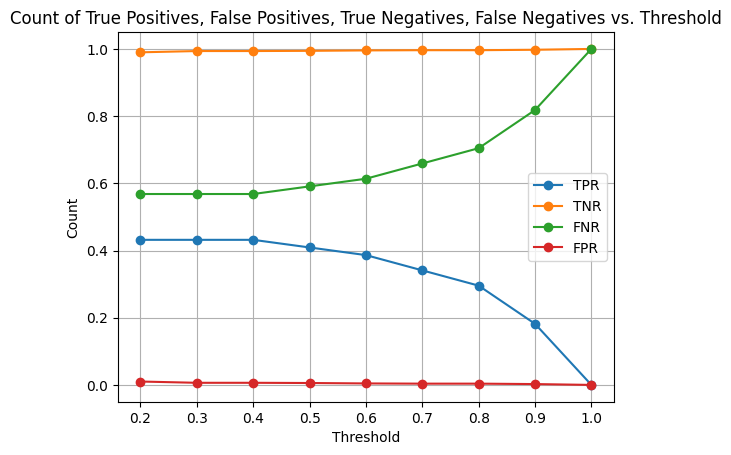

In [ ]:

# make sure it's np
y_test = np.array(y_test)

# plotting against thresholds
thresholds = np.arange(.2, 1.1, 0.1)  # From 0 to 1, with step size of 0.1

# storing the counts for each threshold
true_positives_list = []
false_positives_list = []
true_negatives_list = []
false_negatives_list = []
tpr_list = []
fpr_list = []
tnr_list= []
fnr_list= []

for threshold in thresholds:
    #already doing this but diong it just because
    binary_predictions = (predictions > threshold).astype(int).flatten()

    # calculations
    true_positives = np.sum((binary_predictions == 1) & (y_test == 1))
    false_positives = np.sum((binary_predictions == 1) & (y_test == 0))
    true_negatives = np.sum((binary_predictions == 0) & (y_test == 0))
    false_negatives = np.sum((binary_predictions == 0) & (y_test == 1))
    tpr = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives)
    fpr = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives)
    tnr = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives)
    fnr = false_negatives / (true_positives + false_negatives) if (true_positives + false_negatives)

    tpr_list.append(tpr)
    fpr_list.append(fpr)
    fnr_list.append(fnr)
    tnr_list.append(tnr)
    true_positives_list.append(true_positives)
    false_positives_list.append(false_positives)
    true_negatives_list.append(true_negatives)
    false_negatives_list.append(false_negatives)

# Plotting the results

plt.plot(thresholds, tpr_list, label='TPR', marker='o')
plt.plot(thresholds, tnr_list, label='TNR', marker='o')
plt.plot(thresholds, fnr_list, label='FNR', marker='o')
plt.plot(thresholds, fpr_list, label='FPR', marker='o')

plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('Count of True Positives, False Positives, True Negatives, False Negatives vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
binary_predictions = (predictions > .5).astype(int).flatten()

true_positives = np.sum((binary_predictions == 1) & (y_test == 1))
false_positives = np.sum((binary_predictions == 1) & (y_test == 0))
true_negatives = np.sum((binary_predictions == 0) & (y_test == 0))
false_negatives = np.sum((binary_predictions == 0) & (y_test == 1))

tpr = true_positives / (true_positives + false_negatives)
fpr = false_positives / (false_positives + true_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fnr = false_negatives / (true_positives + false_negatives)

print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Negatives: {false_negatives}")
print(f"TPR: {tpr}")
print(f"FPR: {fpr}")
print(f"TNR: {tnr}")
print(f"FNR: {fnr}") #without it being for threshold val .5 (can also subset from the list above)

True Positives: 18
False Positives: 9
True Negatives: 1574
False Negatives: 26
TPR: 0.4090909090909091
FPR: 0.005685407454200884
TNR: 0.9943145925457991
FNR: 0.5909090909090909


## Metrics for our classification:

In [ ]:
from sklearn.metrics import roc_curve, f1_score, roc_auc_score, classification_report, auc #imports

In [ ]:
y_pred_probs = model.predict([test_data[0], test_data[1]])

y_pred = (y_pred_probs > 0.5).astype(int)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
f1 = f1_score(y_test, y_pred)
print("F1-Score: ", str(f1))

F1-Score:  0.5070422535211268


In [ ]:
auc = roc_auc_score(y_test, y_pred_probs)
print("AUC value: ", auc)

AUC value:  0.6743740308964568


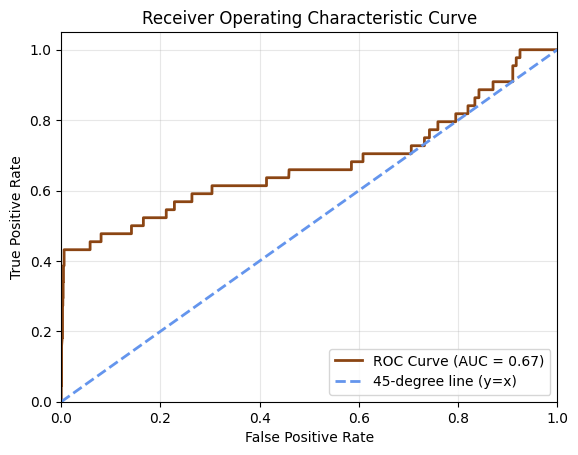

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)  # predictions are probabilities
roc_auc = auc(fpr, tpr)

#plot ROC
plt.plot(fpr, tpr, color='saddlebrown', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='cornflowerblue', lw=2, linestyle='--', label='45-degree line (y=x)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
precision = true_positives / (true_positives + false_positives)
precision

0.6666666666666666

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1583
           1       0.67      0.41      0.51        44

    accuracy                           0.98      1627
   macro avg       0.83      0.70      0.75      1627
weighted avg       0.98      0.98      0.98      1627



## Data Exploration

This would theoretcially go before the CNN and such but I wanted to get that out of the way first because I was worried about my code working.

In [ ]:
all_image_paths = pd.concat([subset_processed['Image Path 1'], subset_processed['Image Path 2']])

unique_image_paths = all_image_paths.drop_duplicates() #removing duplicates

path_to_text_mapping = df.set_index('Image Path')['Text'].to_dict()

associated_array = [(path, path_to_text_mapping.get(path, None)) for path in unique_image_paths]

associated_df = pd.DataFrame(associated_array, columns=['Image Path', 'Text']) #to a pandas df

print(associated_df)

                                             Image Path  \
0     /content/gdrive/MyDrive/P3/lines/g03/g03-043/g...   
1     /content/gdrive/MyDrive/P3/lines/h07/h07-080/h...   
2     /content/gdrive/MyDrive/P3/lines/m04/m04-131/m...   
3     /content/gdrive/MyDrive/P3/lines/r03/r03-110/r...   
4     /content/gdrive/MyDrive/P3/lines/e04/e04-119/e...   
...                                                 ...   
9381  /content/gdrive/MyDrive/P3/lines/d04/d04-131/d...   
9382  /content/gdrive/MyDrive/P3/lines/a01/a01-122u/...   
9383  /content/gdrive/MyDrive/P3/lines/g06/g06-045l/...   
9384  /content/gdrive/MyDrive/P3/lines/c06/c06-027/c...   
9385  /content/gdrive/MyDrive/P3/lines/g06/g06-037l/...   

                                                   Text  
0                   subjects, for being well acquainted  
1            industrial selection scheme by arrangement  
2                On the back seat Stan Hayball embraced  
3        and some in West Hampstead for four two fifty,  
4

In [ ]:
associated_df['Word Count'] = associated_df['Text'].apply(lambda s: len(s.split()) if pd.notnull(s) else 0) #initalizing and filling word count column

print(associated_df)

                                             Image Path  \
0     /content/gdrive/MyDrive/P3/lines/g03/g03-043/g...   
1     /content/gdrive/MyDrive/P3/lines/h07/h07-080/h...   
2     /content/gdrive/MyDrive/P3/lines/m04/m04-131/m...   
3     /content/gdrive/MyDrive/P3/lines/r03/r03-110/r...   
4     /content/gdrive/MyDrive/P3/lines/e04/e04-119/e...   
...                                                 ...   
9381  /content/gdrive/MyDrive/P3/lines/d04/d04-131/d...   
9382  /content/gdrive/MyDrive/P3/lines/a01/a01-122u/...   
9383  /content/gdrive/MyDrive/P3/lines/g06/g06-045l/...   
9384  /content/gdrive/MyDrive/P3/lines/c06/c06-027/c...   
9385  /content/gdrive/MyDrive/P3/lines/g06/g06-037l/...   

                                                   Text  Word Count  
0                   subjects, for being well acquainted           5  
1            industrial selection scheme by arrangement           5  
2                On the back seat Stan Hayball embraced           7  
3        an

In [ ]:
associated_df['Word Count'].mean()

7.548369912635841

In [ ]:
associated_df['Word Count'].std()

2.1247342134616103

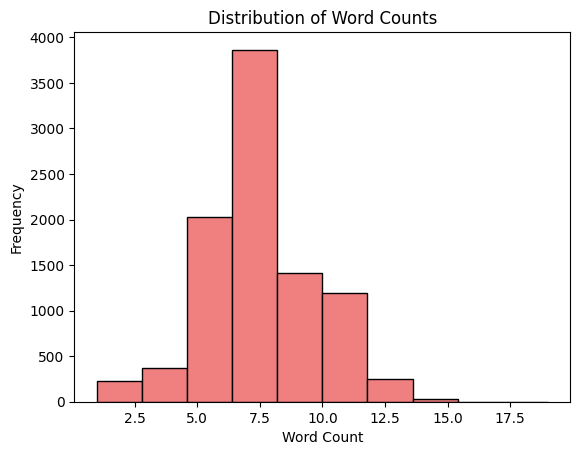

In [ ]:
plt.hist(associated_df['Word Count'], bins=10, edgecolor='k', color = "lightcoral")
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

In [ ]:
associated_df['Character Count'] = associated_df['Text'].apply(len)

In [ ]:
print(associated_df['Character Count'].mean(), associated_df['Character Count'].std())

42.729490730875774 10.433870591034934


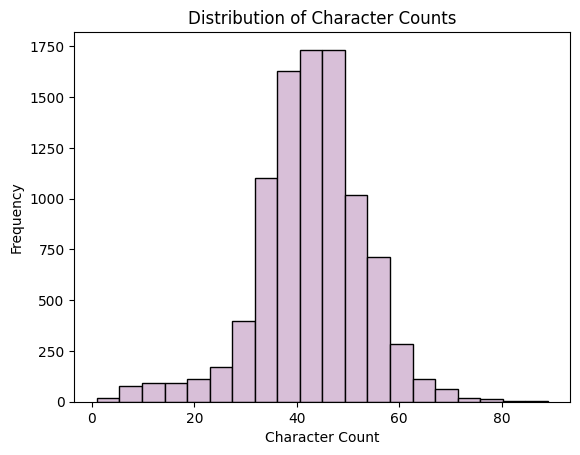

In [ ]:
plt.hist(associated_df['Character Count'], bins=20, edgecolor='k', color = "thistlebas")
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Distribution of Character Counts')
plt.show()

In [ ]:
num_rows = len(associated_df)
num_rows

9386